## Imports

In [43]:
import os
import pysam
import upsetplot

import numpy as np
import pandas as pd
import matplotlib.cm as cm

from google.cloud import storage
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

/tmp/ipykernel_102/2722540625.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [44]:
# ! pip install upsetplot

## Constants

### User Inputs

In [45]:
use_cache = True

subset = "clustered_raw_calls"
# subset = "filtered"

vcf1 = "conc_dragen_by_manta"
vcf2 = "conc_manta_by_dragen"

vcf1_name = "DRAGEN-SV"
vcf2_name = "Manta"

min_size_cache = None
max_size_cache = None
valid_types_cache = None

min_size_filter = None
max_size_filter = None
valid_types_filter = None

sr_callers = ["depth", "dragen", "manta", "scramble", "wham"]
    
info_fields = ["AF", "STRAT", "TRUTH_VID"]

### Additional

In [46]:
in_dir = f"/home/jupyter/Files/overlap_sites/inputs/{subset}"
out_dir = f"/home/jupyter/Files/overlap_sites/outputs/{subset}"
os.makedirs(out_dir, exist_ok=True)

vcf1_file_path = os.path.join(in_dir, f"{vcf1}.vcf.gz")
vcf1_output_path = os.path.join(out_dir, f"{vcf1}.tsv")

vcf2_file_path = os.path.join(in_dir, f"{vcf2}.vcf.gz")
vcf2_output_path = os.path.join(out_dir, f"{vcf2}.tsv")

cached_df_path = os.path.join(out_dir, f"{subset}.cached.tsv")

In [47]:
chrom_order = {f'chr{i}': i for i in range(1, 23)}
chrom_order.update({'chrX': 23, 'chrY': 24})

In [48]:
SV_ORDER = ['BND', 'CNV', 'CPX', 'CTX', 'DEL', 'DUP', 'INS', 'INV']
cmap = cm.get_cmap('Set2', len(SV_ORDER))
COLOR_MAP = {sv: cmap(i) for i, sv in enumerate(SV_ORDER)}

/tmp/ipykernel_102/3414658682.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(SV_ORDER))


## Helper Functions

In [49]:
def assign_strat(s):
    if pd.isna(s):
        return "Unique"
    if "TR_" in s:
        return "TR"
    elif "SR_" in s:
        return "SR"
    elif "SD_" in s:
        return "SD"
    elif "RM_" in s:
        return "RM"
    else:
        return "Unique"

In [50]:
def plot_upset_support(df, source_display=('vcf1','vcf2'), ylim=None):
    disp1, disp2 = source_display

    sup1 = df[(df.SOURCE=='vcf1') & (df.STATUS_SITE==1)]['SVTYPE'].value_counts()
    sup2 = df[(df.SOURCE=='vcf2') & (df.STATUS_SITE==1)]['SVTYPE'].value_counts()

    overlap = ((sup1.add(sup2, fill_value=0) / 2).round().astype(int))
    excl1 = df[(df.SOURCE=='vcf1') & (df.STATUS_SITE==0)]['SVTYPE'].value_counts()
    excl2 = df[(df.SOURCE=='vcf2') & (df.STATUS_SITE==0)]['SVTYPE'].value_counts()

    rows = []
    for sv, cnt in overlap.items():
        rows += [{disp1: True,  disp2: True,  'SVTYPE': sv}] * cnt
    for sv, cnt in excl1.items():
        rows += [{disp1: True,  disp2: False, 'SVTYPE': sv}] * cnt
    for sv, cnt in excl2.items():
        rows += [{disp1: False, disp2: True,  'SVTYPE': sv}] * cnt

    upset_df = pd.DataFrame(rows).set_index([disp1, disp2])
    upset = upsetplot.UpSet(
        upset_df,
        subset_size='count',
        intersection_plot_elements=0,
        sort_by='cardinality'
    )
    upset.add_stacked_bars(by='SVTYPE', colors=COLOR_MAP, title='Sites', elements=10)

    fig = plt.figure(dpi=100)
    axes = upset.plot(fig=fig)
    
    if ylim is not None:
        axes['extra0'].set_ylim(ylim)

    axes['extra0'].legend(
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    plt.show()

## Process

### Verification

In [51]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [52]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [53]:
# Load VCF 1

if not use_cache:
    gcs_client = storage.Client()
    
    with open(vcf1_output_path, "w") as tsv:
        pass
    
    with pysam.VariantFile(vcf1_file_path) as vcf, open(vcf1_output_path, "a") as tsv:
        tsv.write(
            "\t".join(
                ["VID", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS_SITE"]
                + [sc.upper() for sc in sr_callers]
                + info_fields
            )
            + "\n"
        )
        
        for r in vcf:
            svtype = r.info.get("SVTYPE", None)
            svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
            svlen = -1 if svlen == 0 else svlen
            filters = ",".join(f for f in r.filter)

            if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
            
            if max_size_cache is not None:
                if svlen > max_size_cache:
                    continue

            if min_size_cache is not None:
                if svlen < min_size_cache:
                    continue
                    
            base = [
                r.id,
                r.chrom,
                r.pos,
                svtype,
                svlen,
                filters,
                1 if r.info.get("STATUS", "") == "TP" else 0
            ]

            algos = r.info.get("ALGORITHMS", [])
            if isinstance(algos, str):
                algos = [algos]

            sr_flags = []
            for sc in sr_callers:
                if sc in algos:
                    sr_flags.append(1)
                else:
                    sr_flags.append(0)
            
            infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
            
            row = base + sr_flags + infs
            tsv.write("\t".join(str(x) for x in row) + "\n")

In [54]:
# Load VCF 2

if not use_cache:
    gcs_client = storage.Client()
    
    with open(vcf2_output_path, "w") as tsv:
        pass
    
    with pysam.VariantFile(vcf2_file_path) as vcf, open(vcf2_output_path, "a") as tsv:
        tsv.write(
            "\t".join(
                ["VID", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS_SITE"]
                + [sc.upper() for sc in sr_callers]
                + info_fields
            )
            + "\n"
        )
        
        for r in vcf:
            svtype = r.info.get("SVTYPE", None)
            svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
            svlen = -1 if svlen == 0 else svlen
            filters = ",".join(f for f in r.filter)

            if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
            
            if max_size_cache is not None:
                if svlen > max_size_cache:
                    continue

            if min_size_cache is not None:
                if svlen < min_size_cache:
                    continue
                    
            base = [
                r.id,
                r.chrom,
                r.pos,
                svtype,
                svlen,
                filters,
                1 if r.info.get("STATUS", "") == "TP" else 0
            ]

            algos = r.info.get("ALGORITHMS", [])
            if isinstance(algos, str):
                algos = [algos]

            sr_flags = []
            for sc in sr_callers:
                if sc in algos:
                    sr_flags.append(1)
                else:
                    sr_flags.append(0)
            
            infs = [r.info.get(k, None) for k in info_fields if k in info_fields]
            
            row = base + sr_flags + infs
            tsv.write("\t".join(str(x) for x in row) + "\n")

### Dataframe Processing

In [55]:
# Format VCF 1

if not use_cache:
    df1 = pd.read_csv(vcf1_output_path, sep="\t")

    # Set column types
    df1 = df1.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
        
    # Process AF
    clean = df1["AF"].str.replace(r"[(),]", "", regex=True)
    df1["AF"] = pd.to_numeric(clean, errors="coerce")

    # Process STRAT
    def assign_strat(s):
        if pd.isna(s):
            return "Unique"
        if "TR_" in s:
            return "TR"
        elif "SR_" in s:
            return "SR"
        elif "SD_" in s:
            return "SD"
        elif "RM_" in s:
            return "RM"
        else:
            return "Unique"
    df1["STRAT"] = df1["STRAT"].apply(assign_strat)

    # Process categorical
    df1['SVTYPE'] = pd.Categorical(df1['SVTYPE'])
    df1['STRAT'] = pd.Categorical(df1['STRAT'])
    
    # Set log_SVLEN
    df1["log_SVLEN"] = np.log10(df1["SVLEN"].where(df1["SVLEN"] > 0, np.nan))

    # Set SIZE
    df1["SIZE"] = df1["SVLEN"]
    df1.loc[df1["SVTYPE"] == "DEL", "SIZE"] = -df1.loc[df1["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df1["SRWGS"] = df1.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df1["SUPPORT"] = "Unsupported"
    df1.loc[(df1["SRWGS"] == 1) & (df1["STATUS_SITE"] == 1), "SUPPORT"] = "Supported"
    df1['SUPPORT'] = pd.Categorical(df1['SUPPORT'])
    
    # Set SOURCE
    df1["SOURCE"] = "vcf1"

In [56]:
# Format VCF 2

if not use_cache:
    df2 = pd.read_csv(vcf2_output_path, sep="\t")

    # Set column types
    df2 = df2.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
        
    # Process AF
    clean = df2["AF"].str.replace(r"[(),]", "", regex=True)
    df2["AF"] = pd.to_numeric(clean, errors="coerce")

    # Process STRAT
    df2["STRAT"] = df2["STRAT"].apply(assign_strat)

    # Process categorical
    df2['SVTYPE'] = pd.Categorical(df2['SVTYPE'])
    df2['STRAT'] = pd.Categorical(df2['STRAT'])
    
    # Set log_SVLEN
    df2["log_SVLEN"] = np.log10(df2["SVLEN"].where(df2["SVLEN"] > 0, np.nan))

    # Set SIZE
    df2["SIZE"] = df2["SVLEN"]
    df2.loc[df2["SVTYPE"] == "DEL", "SIZE"] = -df2.loc[df2["SVTYPE"] == "DEL", "SIZE"]

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df2["SRWGS"] = df2.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df2["SUPPORT"] = "Unsupported"
    df2.loc[(df2["SRWGS"] == 1) & (df2["STATUS_SITE"] == 1), "SUPPORT"] = "Supported"
    df2["SUPPORT"] = pd.Categorical(df2['SUPPORT'])
    
    # Set SOURCE
    df2["SOURCE"] = "vcf2"

In [57]:
if not use_cache:
    df = pd.concat([df1, df2], ignore_index=True)
    df["SOURCE"] = pd.Categorical(df["SOURCE"])
    
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [58]:
df = pd.read_csv(cached_df_path, sep="\t")

df.head()

,VID,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,DEPTH,DRAGEN,MANTA,SCRAMBLE,WHAM,AF,STRAT,TRUTH_VID,log_SVLEN,SIZE,SRWGS,SUPPORT,SOURCE
0,all_samples_dragen_chr1_00000000,chr1,10296,DEL,63,NaN,1,0,1,0,0,0,0.008511,TR,all_samples_manta_chr1_00000000,1.799341,-63,1,Supported,vcf1
1,all_samples_dragen_chr1_00000001,chr1,10574,BND,-1,NaN,0,0,1,0,0,0,0.002128,Unique,NaN,NaN,-1,1,Unsupported,vcf1
2,all_samples_dragen_chr1_00000002,chr1,50937,DEL,117,NaN,0,0,1,0,0,0,0.002128,SD,NaN,2.068186,-117,1,Unsupported,vcf1
3,all_samples_dragen_chr1_00000003,chr1,54715,INS,52,NaN,1,0,1,0,0,0,0.053000,TR,all_samples_manta_chr1_00000001,1.716003,52,1,Supported,vcf1
4,all_samples_dragen_chr1_00000004,chr1,83960,INS,94,NaN,1,0,1,0,0,0,0.015000,TR,all_samples_manta_chr1_00000002,1.973128,94,1,Supported,vcf1


In [59]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])
df['STRAT'] = pd.Categorical(df['STRAT'])
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])
df['SOURCE'] = pd.Categorical(df['SOURCE'])

conditions = [
    df["AF"] < 0.01,
    df["AF"] < 0.05,
    df["AF"] < 0.2,
    df["AF"] < 0.5
]
choices = [
    "AF < 1%",
    "1% ≤ AF < 5%",
    "5% ≤ AF < 20%",
    "20% ≤ AF < 50%"
]
df["AF_BUCKET"] = np.select(conditions, choices, default="AF > 50%")
df["AF_BUCKET"] = pd.Categorical(
    df["AF_BUCKET"],
    categories=["AF < 1%", "1% ≤ AF < 5%", "5% ≤ AF < 20%", "20% ≤ AF < 50%", "AF > 50%"],
    ordered=True
)

In [60]:
# Filtering
  
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
# if valid_types_filter is not None:
#     bef = len(df)
#     df = df[df["SVTYPE"].isin(valid_types_filter)]
#     print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-PASS FILTER
# bef = len(df)
# df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
# print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-Caller variants
# caller = "DRAGEN" if run == "evaluation" else "MANTA"
# bef = len(df)
# df = df[df[caller] == 1]
# print(f"[{caller} only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

,VID,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS_SITE,DEPTH,DRAGEN,MANTA,...,WHAM,AF,STRAT,TRUTH_VID,log_SVLEN,SIZE,SRWGS,SUPPORT,SOURCE,AF_BUCKET
0,all_samples_dragen_chr1_00000000,chr1,10296,DEL,63,NaN,1,0,1,0,...,0,0.008511,TR,all_samples_manta_chr1_00000000,1.799341,-63,1,Supported,vcf1,AF < 1%
1,all_samples_dragen_chr1_00000001,chr1,10574,BND,-1,NaN,0,0,1,0,...,0,0.002128,Unique,NaN,NaN,-1,1,Unsupported,vcf1,AF < 1%
2,all_samples_dragen_chr1_00000002,chr1,50937,DEL,117,NaN,0,0,1,0,...,0,0.002128,SD,NaN,2.068186,-117,1,Unsupported,vcf1,AF < 1%
3,all_samples_dragen_chr1_00000003,chr1,54715,INS,52,NaN,1,0,1,0,...,0,0.053000,TR,all_samples_manta_chr1_00000001,1.716003,52,1,Supported,vcf1,5% ≤ AF < 20%
4,all_samples_dragen_chr1_00000004,chr1,83960,INS,94,NaN,1,0,1,0,...,0,0.015000,TR,all_samples_manta_chr1_00000002,1.973128,94,1,Supported,vcf1,1% ≤ AF < 5%


## Analyze

In [61]:
# Print statistics of support by VCF

gb = df.groupby('SOURCE')['STATUS_SITE']

total = gb.count()
supported = gb.sum()
pct_supported = (supported / total * 100).round(2)

summary = pd.DataFrame({
    'total_variants': total,
    'supported_variants': supported,
    'percent_supported': pct_supported
})

print(summary)

        total_variants  supported_variants  percent_supported
SOURCE                                                       
vcf1             74888               60480              80.76
vcf2             63136               60142              95.26


In [62]:
# Print statistics of symmetric support by VCF 

supported = df[df['STATUS_SITE'] == 1]
sup1 = supported[supported['SOURCE'] == 'vcf1'][['VID', 'TRUTH_VID']]
sup2 = supported[supported['SOURCE'] == 'vcf2'][['VID', 'TRUTH_VID']]

pairs1 = set(map(tuple, sup1.values))
pairs2 = set(map(tuple, sup2.values))

sym1 = sum(1 for (x,y) in pairs1 if (y, x) in pairs2)
sym2 = sum(1 for (x,y) in pairs2 if (y, x) in pairs1)

tot1 = len(pairs1)
tot2 = len(pairs2)
pct1 = (sym1 / tot1 * 100) if tot1 else 0
pct2 = (sym2 / tot2 * 100) if tot2 else 0

sym_summary = pd.DataFrame({
    'total_supported': [tot1, tot2],
    'symmetric_supported': [sym1, sym2],
    'percent_symmetric': [round(pct1,2), round(pct2,2)]
}, index=['vcf1','vcf2'])

print(sym_summary)

      total_supported  symmetric_supported  percent_symmetric
vcf1            60480                59795              98.87
vcf2            60142                59795              99.42


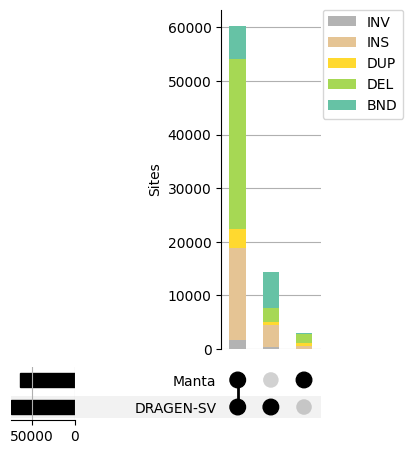

In [63]:
plot_upset_support(df, source_display=(vcf1_name, vcf2_name))